In [10]:
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    create_intersection_dataloader,
)
from tree_detection_framework.detection.detector import (
    GeometricTreeTopDetector,
    GeometricTreeCrownDetector,
)
from tree_detection_framework.postprocessing.postprocessing import (
    remove_edge_detections,
    suppress_tile_boundary_with_NMS,
    multi_region_NMS
)

In [11]:
RASTER_FOLDER_PATH = "/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/chm.tif"
CHIP_SIZE = 512
CHIP_STRIDE = 400
RESOLUTION = 0.2

In [12]:
# Stage 1: Create a dataloader for the raster data and detect the tree-tops
dataloader = create_dataloader(
    raster_folder_path=RASTER_FOLDER_PATH,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    resolution=RESOLUTION,
)

treetop_detector = GeometricTreeTopDetector(a=0.0020, c=1, confidence_feature="height")  # a=0.0045

treetop_detections = treetop_detector.predict(dataloader)

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 400
Performing prediction on batches: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


In [13]:
# Remove the tree tops that were generated in the edges of tiles. This is an alternative to NMS.
treetop_detections = remove_edge_detections(
    treetop_detections,
    suppression_distance=(CHIP_SIZE - CHIP_STRIDE) * RESOLUTION / 2,
)

In [14]:
# Optionally, save the treetops to disk
treetop_detections.save("/ofo-share/repos-amritha/tree-detection-framework/data/saved-gpkgs/geo_detector_treetops2.gpkg")

INFO:pyogrio._io:Created 1,159 records


In [22]:
# Stage 2: Combine raster and vector data (from the tree-top detector) to create a new dataloader
raster_vector_dataloader = create_intersection_dataloader(
    raster_data=RASTER_FOLDER_PATH,
    vector_data=treetop_detections,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    resolution=RESOLUTION,
)

treecrown_detector = GeometricTreeCrownDetector(approach="watershed")

treecrown_detections = treecrown_detector.predict(raster_vector_dataloader)

INFO:root:Stride = 400
INFO:root:Units = Units.PIXELS
INFO:pyogrio._io:Created 1,159 records
INFO:root:RegionDetectionsSet temporarily saved to: /tmp/tmpym7614q8.geojson


Converting CustomRasterDataset CRS from EPSG:26910 to EPSG:26910


INFO:root:Using watershed approach to compute the tree crowns.
Performing prediction on batches: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


In [23]:
# Suppress overlapping crown predictions. This step can be slow.
treecrown_detections = multi_region_NMS(
    treecrown_detections, confidence_column="score", intersection_method="IOS"
)

INFO:root:Bound have overlap, running across-region NMS


In [25]:
# Display outputs from the tree crown detector. Note: treetop UIDs get maintained.
treecrown_detections.get_data_frame()

,score,height,treetop_unique_ID,geometry,region_ID,unique_ID
1,155.0,17.778465,00485,"POLYGON ((752324.69 4317073.299, 752324.69 431...",0,00001
9,2.0,21.050888,00382,"POLYGON ((752294.69 4317062.699, 752294.69 431...",0,00009
14,612.0,32.637424,00496,"POLYGON ((752320.89 4317065.099, 752320.89 431...",0,00014
20,258.0,19.044992,00389,"POLYGON ((752254.69 4317059.299, 752254.69 431...",0,00020
26,983.0,32.866383,00391,"POLYGON ((752274.09 4317060.899, 752274.09 431...",0,00026
...,...,...,...,...,...,...
1667,1152.0,41.333351,01147,"POLYGON ((752457.29 4317220.499, 752457.29 431...",11,01667
1668,1497.0,35.046040,01145,"POLYGON ((752438.69 4317221.499, 752438.69 431...",11,01668
1669,506.0,13.274141,01150,"POLYGON ((752449.89 4317217.499, 752449.89 431...",11,01669
1673,628.0,19.464565,01151,"POLYGON ((752398.69 4317218.099, 752398.69 431...",11,01673


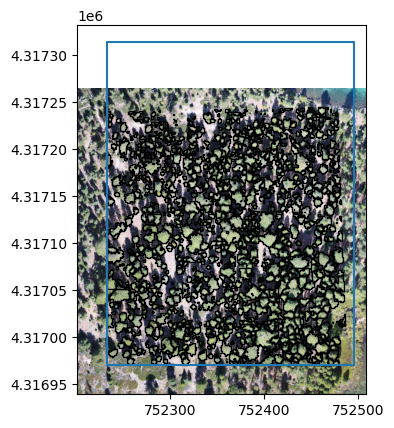

In [26]:
treecrown_detections.plot(
    raster_file="/ofo-share/repos-amritha/tree-detection-framework/data/emerald-point-ortho/ortho.tif"
)

In [27]:
treecrown_detections.save("/ofo-share/repos-amritha/tree-detection-framework/data/saved-gpkgs/geo_detector_watershed2.gpkg")

INFO:pyogrio._io:Created 1,135 records
